In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '32'
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import math
import sys
sys.path.append('../')
from pyfd3d import pyfd3d
from pyMKL import pardisoSolver
import pyfd3d.fd3d as fd3d
from scipy.sparse.linalg import qmr, bicgstab, lgmres, gcrotmk

In [2]:
Nz = 210
Npml = np.array([0,0,15])

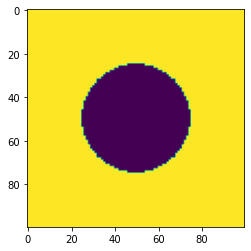

In [3]:
L0 = 1e-6
## specify slab plane
xrange = yrange = np.array([-0.5,0.5])
zrange = [-1,1];
radius = 0.25
Nx = Ny = 100

x = np.linspace(xrange[0], xrange[1], Nx)
y = np.linspace(yrange[0], yrange[1], Ny)
z = np.linspace(zrange[0], zrange[1], Nz)
xx,yy = np.meshgrid(x,y)

slab_plane = 4*np.ones((Nx,Ny))

slab_plane[xx**2+yy**2<radius**2] = 1
plt.imshow(slab_plane)

In [4]:
## integrate slab structure into 3D grid
eps_r = np.ones((Nx,Ny,Nz))
N = [Nx,Ny,Nz]

In [5]:
print(eps_r.shape)
for k in range(100,150):
    eps_r[:,:,k] = slab_plane

(100, 100, 210)


In [6]:
Jz = np.zeros(N); 
Jy = np.zeros(N);
Jx = np.zeros(N);
Jx[:,:,35] = 1;
Jy[:,:,35] = 1
eps_r_tensor_dict = {
    'eps_xx': eps_r,
    'eps_yy': eps_r.copy(),
    'eps_zz': eps_r.copy(),
}
JCurrentVector = {
    'Jx': Jx,
    'Jy': Jy,
    'Jz': Jz
}


In [7]:
wvlen = 0.51;
print(L0, xrange, yrange, zrange)

A,b, Ch = fd3d.curlcurlE(L0, 
                         wvlen, 
                         xrange, 
                         yrange, 
                         zrange, 
                         eps_r_tensor_dict, 
                         JCurrentVector,Npml, 
                         s = -1
                        )

1e-06 [-0.5  0.5] [-0.5  0.5] [-1, 1]
(6300000,)


## Notes
1. hmmm, seems like bicg-stab fails on this system?

In [8]:
## ilu preconditioner?
from scipy.sparse.linalg import spilu


In [ ]:
%%time
x, info = gcrotmk(A,b, maxiter = 2000, atol = 1e-3);
print(info)

<timed exec>:1: DeprecationWarning: scipy.sparse.linalg.gcrotmk called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


In [ ]:
print(info) #system did not converge?

In [ ]:
y = Ch@x
print(y.shape, A.shape)

In [ ]:
M = np.prod(N);
Ex = x[0:M].reshape(N, order = 'F');
Ey = x[M:2*M].reshape(N, order = 'F')
Ez = x[2*M:].reshape(N, order = 'F')

Hx =  y[0:M].reshape(N, order = 'F')
Hy =  y[M:2*M].reshape(N, order = 'F')
Hz =  y[2*M:].reshape(N, order = 'F')


In [ ]:
for i in range(0,N[0],2):
    plt.figure()
    #plt.imshow(np.abs(Ex[:,i,:]), cmap = 'hot')
    plt.imshow(np.real(Ex[:,i,:]), cmap = 'RdBu')

    #plt.clim(0,0.5e-2)
    plt.colorbar()
    

In [ ]:
for i in range(0,N[-1],5):
    plt.figure()
    plt.imshow(np.real(Ex[:,:,i]), cmap = 'RdBu')
    plt.clim(-0.5, 0.5)
    plt.colorbar()

In [ ]:
print('error norm: ',np.linalg.norm(A@x-b)/np.linalg.norm(b))
print('error norm should be small, ideally close to precision')
plt.plot(np.abs(A@x))
plt.plot(np.abs(b))
plt.legend(('solution','actual'))



In [ ]:
print(np.allclose(A@x, b))

In [ ]:
plt.plot(np.abs(x))